In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt

In [10]:
df = pd.read_csv("../data/Healthcare_Workforce_Mental_Health_Dataset.csv")
df.head()

,Employee ID,Employee Type,Department,Workplace Factor,Stress Level,Burnout Frequency,Job Satisfaction,Access to EAPs,Mental Health Absences,Turnover Intention
0,HCP-00001,Pediatric Nurse,Pediatrics,Heavy Workload,8,Often,2,Yes,6,No
1,HCP-00002,Laboratory Technician,Laboratory,Safety Concerns,8,Often,1,Yes,12,No
2,HCP-00003,Nursing Assistant,Assisted Living,Poor Work Environment,6,Occasionally,2,Yes,9,Yes
3,HCP-00004,Medical Assistant,Outpatient Services,Poor Work Environment,7,Never,4,No,11,No
4,HCP-00005,Registered Nurse,General Medicine,Work-Life Imbalance,8,Occasionally,2,Yes,7,No


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Employee ID             5000 non-null   object
 1   Employee Type           5000 non-null   object
 2   Department              5000 non-null   object
 3   Workplace Factor        5000 non-null   object
 4   Stress Level            5000 non-null   int64 
 5   Burnout Frequency       5000 non-null   object
 6   Job Satisfaction        5000 non-null   int64 
 7   Access to EAPs          5000 non-null   object
 8   Mental Health Absences  5000 non-null   int64 
 9   Turnover Intention      5000 non-null   object
dtypes: int64(3), object(7)
memory usage: 390.8+ KB


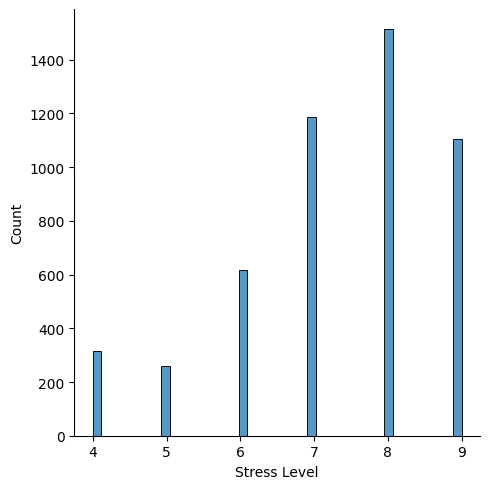

In [13]:
sns.displot(df["Stress Level"])

In [14]:
df["Stress Level"].value_counts(normalize=True)

Stress Level
8    0.3026
7    0.2376
9    0.2212
6    0.1234
4    0.0634
5    0.0518
Name: proportion, dtype: float64

In [15]:
df.corr(numeric_only=True)

,Stress Level,Job Satisfaction,Mental Health Absences
Stress Level,1.000000,-0.383411,0.501937
Job Satisfaction,-0.383411,1.000000,-0.186305
Mental Health Absences,0.501937,-0.186305,1.000000


<Axes: >

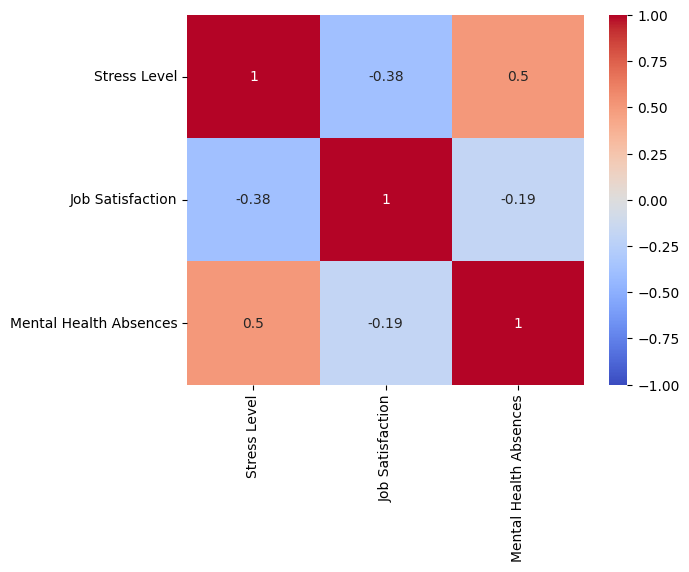

In [16]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", vmin=-1)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# =====================================================
# 1. Cargar datos
# =====================================================


target = "Turnover Intention"         # <-- tu variable a predecir
X = df.drop(columns=[target])
y = df[target]

# =====================================================
# 2. Identificar columnas categóricas y numéricas
# =====================================================

cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(include="number").columns

# Preprocesador para convertir categorías en OHE
preprocess = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("numerical", "passthrough", num_cols)
    ]
)

# =====================================================
# 3. Modelos a evaluar
# =====================================================

models = {
    "Dummy (stratified)": DummyClassifier(strategy="stratified"),
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(n_estimators=150)
}

# =====================================================
# 4. Entrenamiento y evaluación
# =====================================================

for name, model in models.items():
    print("\n===============================")
    print(f"MODEL: {name}")
    print("===============================")

    clf = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# =====================================================
# 5. Importancia de variables (solo para Random Forest)
# =====================================================

rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(n_estimators=150))
])

rf.fit(X_train, y_train)

# Obtener nombres de features tras OHE
ohe = rf.named_steps["preprocess"].named_transformers_["categorical"]
ohe_features = ohe.get_feature_names_out(cat_cols)
all_features = list(ohe_features) + list(num_cols)

importances = rf.named_steps["model"].feature_importances_

feature_importance_df = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\n\nTop 20 variables más importantes:")
print(feature_importance_df.head(20))


=== Classification Report ===
                   precision    recall  f1-score   support

      Anomaly_DoS       0.00      0.00      0.00       199
Anomaly_Injection       0.00      0.00      0.00       113
 Anomaly_Spoofing       0.00      0.00      0.00        98
           Normal       0.79      0.99      0.88      1590

         accuracy                           0.79      2000
        macro avg       0.20      0.25      0.22      2000
     weighted avg       0.63      0.79      0.70      2000

=== Confusion Matrix ===
[[   0    0    0  199]
 [   1    0    0  112]
 [   0    0    0   98]
 [   8    0    0 1582]]


c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b